In [2]:
import scipy.integrate as integrate
import numpy as np
import numpy.linalg as la
from numpy import cross
from numpy.random import rand
import matplotlib.pyplot as plt
import csv
import scipy as sc

from linear_dynamics_LVLH import *

In [3]:
r12 = 384400 # km, distance between primary attractors, from JPL website 389703
mu = 1.215e-2 # no unit, mass parameter of the system, from JPL website 1.215058560962404e-2
TU = 1/(2.661699e-6) # s, inverse of the relative angular frequency between the two primary attractors, from JPL website 382981
L1x = 0.83691513 # nd, position of the L1 point along the x direction
L2x = 1.15568217 # nd, position of the L2 point along the x direction

In [4]:
# Initial conditions, current conditions are for a L2 Southern NRHO

R = np.matrix([[-1, 0, 0],[0, -1, 0],[0, 0, 1]]) # rotation matrix to go from the bary to the Moon frame and conversely (+ translation along x)

# Initial position w.r.t. the barycenter of the Earth-Moon system in the bary frame
x0_bary = 1.0269694420519750E+0 # nd 1.1340389525913128E+0, southern L1 NHRO 9.2280005557282274E-1
y0_bary = -1.0620425026230252E-26 # nd -1.9603275922757012E-28, southern L1 NHRO1.6386233489716853E-28
z0_bary = -1.8530606468865049E-1 # nd -3.1177930540447237E-33, southern L1 NHRO -2.1575768509057866E-1

# nitial position w.r.t. the barycenter of the Earth-Moon system in the Moon frame
initial_position_M = R@np.matrix([x0_bary-(1-mu), y0_bary, z0_bary]).reshape((3,1))
x0_M = initial_position_M[0,0]
y0_M = initial_position_M[1,0]
z0_M = initial_position_M[2,0]

# Initial velocity w.r.t. the barycenter of the Earth-Moon system in the bary frame
vx0_bary = 1.8339007690300910E-14 # nd 5.3802690301291542E-15, southern L1 NHRO 4.4327633188679963E-13
vy0_bary = 	-1.1378551488655682E-1 # nd 1.1050885595242482E-1, southern L1 NHRO 1.2826547451754347E-1
vz0_bary = 1.3151545077882733E-13 # nd 4.2488243310471582E-33, southern L1 NHRO 2.4299327620081873E-12

# Initial velocity w.r.t. the barycenter of the Earth-Moon system in the Moon frame
initial_velocity_M = R@np.matrix([vx0_bary, vy0_bary, vz0_bary]).reshape((3,1))
vx0_M = initial_velocity_M[0,0]
vy0_M = initial_velocity_M[1,0]
vz0_M = initial_velocity_M[2,0]
period = 1.5763752384473892E+0 # nd 3.3898323438578979E+0, southern L1 NHRO 1.8036720655626510E+0

# Initial conditions in the Moon frame for the target spacecraft
initial_conditions_M = [x0_M, y0_M, z0_M, vx0_M, vy0_M, vz0_M]

# Initial conditions in the bary frame for the target spacecraft
initial_conditions_bary = [x0_bary, y0_bary, z0_bary, vx0_bary, vy0_bary, vz0_bary]

# Simulating for 12 hours like in the article
length = 12*3600/TU # nd for a 12-hour simulation
t_simulation = np.linspace(0,period,1000) # change the duration of the simulations HERE

In [5]:
# Setting the initial conditions for the chaser. We'll use the same orbit as the precedent one for the target.
# Initial conditions for the chaser are defined in the LVLH frame

# Maybe do that in another file and save it in a csv file so that the initial conditions don't change everytime we run the code here
# So that we can actually compare results with the same initial conditions more easily
distance_to_target_km = 10 # in km, CHANGE to see to which extent the linear approximation works (try up to 100km in the article)
distance_to_target = distance_to_target_km/r12 # adimensionalized initial condition

rho_x0_LVLH = rand()*distance_to_target # NOT ENTIRELY RANDOM SINCE IT CAN'T BE NEGATIVE, CHANGE THAT!!! -> is it relevant?
rho_y0_LVLH = rand()*np.sqrt(distance_to_target**2 - rho_x0_LVLH**2)
rho_z0_LVLH = np.sqrt(distance_to_target**2 - rho_x0_LVLH**2 - rho_y0_LVLH**2)

velocity_rel_target_km = 0 # in km/s, CHANGE to see to which extent the linear approximation works
velocity_rel_target = velocity_rel_target_km/r12*TU # adimensionalized initial condition

rho_vx0_LVLH = rand()*velocity_rel_target
rho_vy0_LVLH = rand()*np.sqrt(velocity_rel_target**2 - rho_vx0_LVLH**2)
rho_vz0_LVLH = np.sqrt(velocity_rel_target**2 - rho_vx0_LVLH**2 - rho_vy0_LVLH**2)
# print(rho_vx0_LVLH,rho_vy0_LVLH,rho_vz0_LVLH)

# Initial conditions to integrate the relative dynamics
# The initial conditions are in the Moon frame for the target part and in the LVLH frame for the chaser part
initial_conditions_chaser_LVLH = [x0_M, y0_M, z0_M, vx0_M, vy0_M, vz0_M, rho_x0_LVLH, rho_y0_LVLH, rho_z0_LVLH, rho_vx0_LVLH, rho_vy0_LVLH, 
                                  rho_vz0_LVLH]

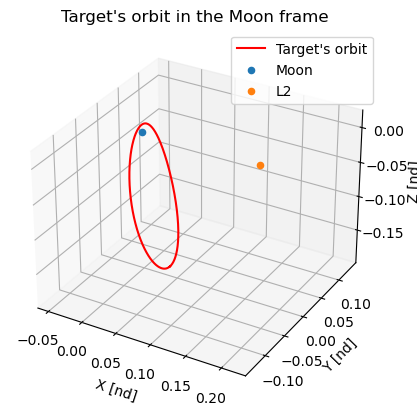

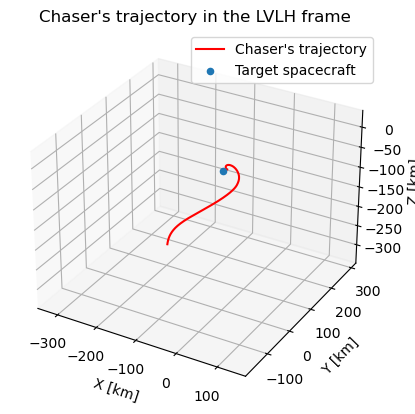

In [6]:
# Simulating the relative dynamics
y_orbit = integrate.odeint(propagator_relative,initial_conditions_chaser_LVLH,t_simulation[:],args=(mu,))

# Plotting of the target's orbit in the Moon (synodic) frame
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(-y_orbit[:,0], -y_orbit[:,1], y_orbit[:,2], color='r', label="Target's orbit")
ax.scatter(0, 0, 0, label='Moon')
ax.scatter(L2x-(1-mu), 0, 0, label='L2')
ax.axis('equal')
ax.set_xlabel('X [nd]')
ax.set_ylabel('Y [nd]')
ax.set_zlabel('Z [nd]')
ax.legend()
plt.title("Target's orbit in the Moon frame")
plt.grid()
plt.show()

# Plotting of the chaser's position in the LVLH frame
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(y_orbit[:,6]*r12, y_orbit[:,7]*r12, y_orbit[:,8]*r12, color='r', label="Chaser's trajectory")
ax.scatter(0, 0, 0, label='Target spacecraft')
ax.axis('equal')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_zlabel('Z [km]')
ax.legend()
plt.title("Chaser's trajectory in the LVLH frame")
plt.grid()
plt.show()

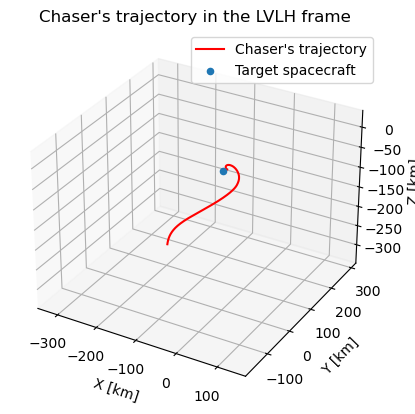

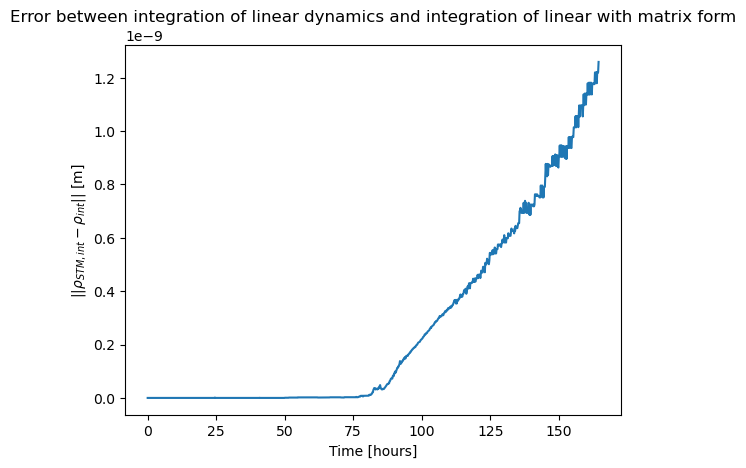

In [7]:
matrix_dyn = integrate.odeint(integrate_matrix,initial_conditions_chaser_LVLH,t_simulation,args=(mu,))

# Plotting of the chaser's position in the LVLH frame
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(matrix_dyn[:,6]*r12, matrix_dyn[:,7]*r12, matrix_dyn[:,8]*r12, color='r', label="Chaser's trajectory")
ax.scatter(0, 0, 0, label='Target spacecraft')
ax.axis('equal')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_zlabel('Z [km]')
ax.legend()
plt.title("Chaser's trajectory in the LVLH frame")
plt.grid()
plt.show()

error_mat_lin = np.zeros(y_orbit.shape[0])
for i in range(y_orbit.shape[0]):
    error = la.norm(matrix_dyn[i,6:9]-y_orbit[i,6:9])
    error_mat_lin[i] = error
    
plt.plot(t_simulation*TU/3600,error_mat_lin*r12*1e3)
plt.xlabel('Time [hours]')
plt.ylabel(r"||$\rho_{STM,int} - \rho_{int}$|| [m]")
plt.title('Error between integration of linear dynamics and integration of linear with matrix form')
plt.show()

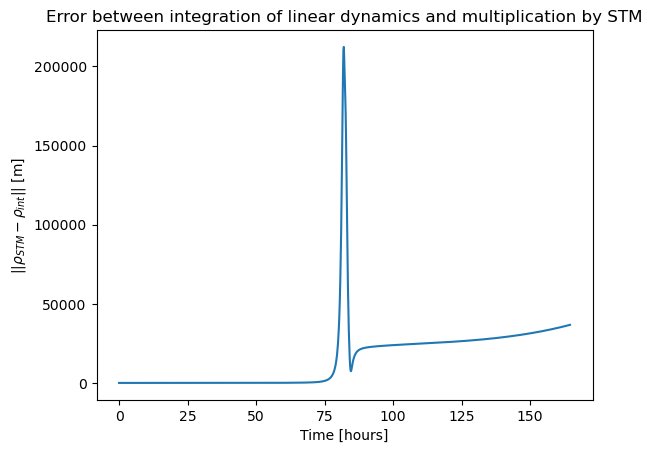

In [8]:

chaser_trajectory_stm = np.zeros_like(y_orbit[:,6:])
chaser_trajectory_stm[0] = (np.asarray(initial_conditions_chaser_LVLH[6:])).reshape(6)
for i in range(1,y_orbit.shape[0]):
    delta_t = t_simulation[i]-t_simulation[i-1] # jouer sur les indices MAIS EN FIXANT LES CONDITIONS INITIALES
    phi = sc.linalg.expm(delta_t*matrix_dynamics(y_orbit[i,:],t_simulation[i],mu)) # jouer sur les indices
    # phi = get_phi(delta_t,matrix_dynamics(y_orbit[i,:],t_simulation[i],mu)) # similar with get_phi and sc.linalg.expm
    chaser_trajectory_stm[i] = (phi @ chaser_trajectory_stm[i-1].reshape((6,1))).reshape(6)

error_stm_lin = np.zeros(y_orbit.shape[0])
for i in range(y_orbit.shape[0]):
    error = la.norm(chaser_trajectory_stm[i,:] - matrix_dyn[i,6:])
    error_stm_lin[i] = error
    
plt.plot(t_simulation*TU/3600,error_stm_lin*r12*1e3)
plt.xlabel('Time [hours]')
plt.ylabel(r"||$\rho_{STM} - \rho_{int}$|| [m]")
plt.title('Error between integration of linear dynamics and multiplication by STM')
plt.show()

# Also plot the error on the velocity